In [ ]:
! pip install emcee corner pytorch-lightning tqdm nflows

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner

/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b)
  Referenced from: '/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/torch/lib/libc10.dylib'
  warn(f"Failed to load image Python extension: {e}")


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/smsharma/sbi-lecture-mit/blob/main/tutorial.ipynb)

# Simulation-based (likelihood-free) inference
**Siddharth Mishra-Sharma** (smsharma@mit.edu)

Simulation-based inference (SBI) is a powerful class of methods for performing inference in settings where the likelihood is computationally intractable, but simulations can be realized via forward modeling. 

In this lecture we will
- Introduce the notion of an implicit likelihood, and how to leverage it to perform inference;
- Look at a "traditional" method for likelihood-free inference, Approximate Bayesian Computation (ABC);
- Build up two common modern _neural_ SBI techniques: neural likelihood-ratio estimation (NRE) and neural posterior estimation (NPE);
- Introduce the concept of statistical coverage testing and calibration.

As examples, we will look at a simple Gaussian-signal-on-power-law-background ("bump hunt"), where the likelihood is tractable, and a more complicated example of inferring a distribution of point sources, where the likelihood is computationally intractable. We will emphasize what it means for a likelihood to be computationally intractable/challenging and where the advantages of SBI come in.

# Simple bump-on-power-law example

As an initial example, consider a Gaussian signal parameterized by {amplitude, mean location, std} on top of a power law background parameterize by {amplitude, power-law exponent}.
$$ x_b = A_b\,y^{n_b} \\
x_s = A_s\,\exp^{-(y - \mu_s)^2 / 2\sigma_s^2}\\
x \sim \mathrm{Pois}(x_b + x_s)$$

In [2]:
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

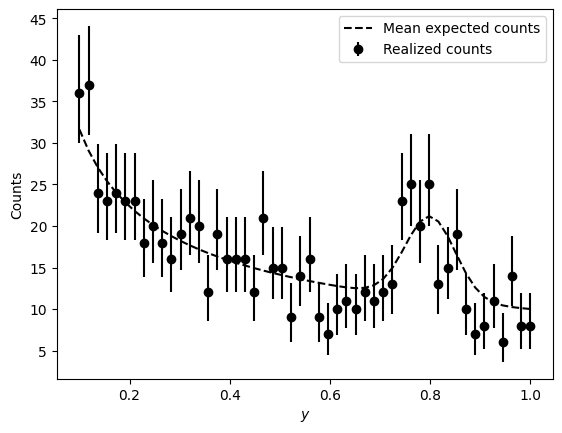

In [18]:
def poisson_interval(k, alpha=0.32): 
    """ Uses chisquared info to get the poisson interval.poisson
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=10, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=10, exp_b=-0.5)  # Background params

# Realized counts
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel("$y$")
plt.ylabel("Counts")

plt.legend()

## The explicit likelihood

In this case, we can write down a log-likelihood as a Poisson over the mean returned by the forward model.

In [149]:
def log_like(theta, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like([100, 0.8, 0.05, 100, -0.5], y, x)

-198.51179791941934

Let's focus on just 2 parameters for simplicity, the signal amplitude and mean location. The likelihood in this case is:

In [150]:
def log_like_sig(params, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 100, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

Get a maximum-liklelihood estimate:

In [154]:
opt = minimize(lambda thetas: -log_like_sig(thetas, y, x), x0=[1, 1])
print("MLE parameters: {}; true parameters: {}".format(opt.x, (100, 0.8)))

MLE parameters: [106.21438853   0.79978264]; true parameters: (100, 0.8)


And approximate posterior using `emcee`:

In [155]:
def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2:
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x)
    
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-2 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:05<00:00, 891.56it/s]


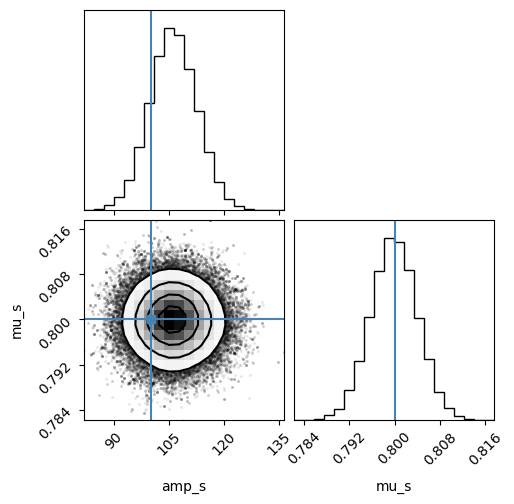

In [160]:
# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8], smooth=1.);

## The implicit likelihood

Now we will do inference without relying on the explicit likelihood evaluation. The key realization is that samples from the forward model implicitly encode the likelihood; when we are simulating data points $x$ for different parameter points $\theta$, we are drawing samples from the likelihood:
$$x\sim p(x\mid\theta)$$
which is where the _implicit_ aspect comes from. Let's write down a bump simulator:

In [167]:
def bump_simulator(thetas, y):
    """ Simulate samples from the bump forward model given theta = (amp_s, mu_s) and abscissa points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 100, -0.5
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    return x

# Test it out
bump_simulator([100, 0.8], y)

array([315, 288, 291, 237, 266, 230, 222, 197, 211, 211, 180, 185, 184,
       146, 171, 156, 146, 165, 155, 146, 148, 134, 159, 134, 153, 135,
       132, 128, 135, 144, 112, 128, 144, 122, 140, 162, 206, 210, 216,
       187, 175, 162, 136, 103, 101, 106, 116,  94,  87, 101])

### Approximate Bayesian Computation (ABC)

The idea behind ABC is to realize samples from the forward model (with the parameters $\theta$ drawn from a prior) and compare it to the dataset of interest $x$. If the data and realized samples are close enough to each other according to some criterion, we keep the parameter points.

The comparison criterion here is a simple MSE on the data points. Play around with the parameters of the forward model to see how the criterion `eps` changes.

In [169]:
x_fwd = bump_simulator([100, 0.8], y)
eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)
eps

537.88

In [173]:
def abc(y, x, eps_thresh=500., n_samples=1000):
    """ABC algorithm for Gaussian bump model.

    Args:
        y (np.ndarray): Abscissa points.
        x (np.ndarray): Data counts.
        eps_thresh (float, optional): Acceptance threshold. Defaults to 500.0.
        n_samples (int, optional): Number of samples after which to stop. Defaults to 1000.

    Returns:
        np.ndarray: Accepted samples approximating the posterior p(theta|x).
    """
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    # Keep simulating until we have enough accepted samples
    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])  # Priors; theta ~ p(theta)
        x_fwd = bump_simulator(params, y)  # x ~ p(x|theta)
        eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)  # Distance metric; d(x, x_fwd)
        total_attempts += 1

        # If accepted, add to samples
        if eps < eps_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)

n_samples = 20_000
post_samples = abc(y, x, eps_thresh=500, n_samples=n_samples)

Accepted Samples: 100%|██████████| 20000/20000 [00:44<00:00, 453.07samples/s, acceptance_ratio=0.020]


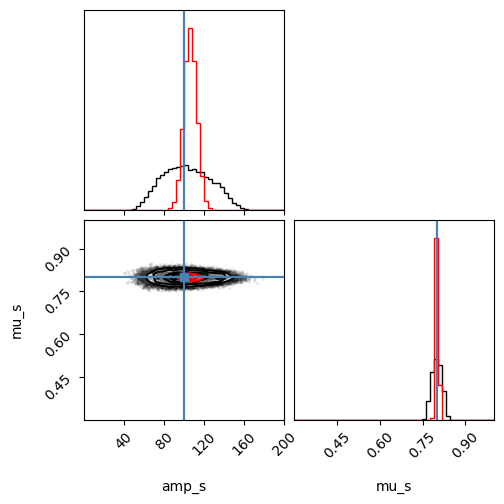

In [174]:
fig = corner.corner(post_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);

### Neural likelihood-ratio estimation (NRE)

Start by creating some training data.

In [175]:
n_train = 50_000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))  # Parameter proposal
x_samples = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

100%|██████████| 50000/50000 [00:00<00:00, 66614.00it/s]


As our parameterized classifier, we will use a simple MLP.

In [176]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

Create a neural ratio estimator class, with a corresponding loss function. The loss is a simple binary cross-entropy loss that discriminates between samples from the joint distribution $\{x, \theta\} \sim p(x\mid\theta)$ and those from a product of marginals $\{x, \theta\} \sim p(x)\,p(\theta)$. Samples from the latter are obtained by shuffling joint samples from within a batch.

In [186]:
class NeuralRatioEstimator(pl.LightningModule):
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, theta):

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)


    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [187]:
# Evaluate loss; initially it should be around -log(0.5) = 0.693
nre = NeuralRatioEstimator(x_dim=50, theta_dim=2)
nre.loss(x_samples[:64], theta_samples[:64])

tensor([0.6614, 0.7259, 0.6593, 0.7282, 0.6591, 0.7285, 0.6595, 0.7281, 0.6593,
        0.7283, 0.6596, 0.7282, 0.6604, 0.7270, 0.6595, 0.7279, 0.6592, 0.7282,
        0.6587, 0.7288, 0.6591, 0.7284, 0.6599, 0.7274, 0.6607, 0.7265, 0.6597,
        0.7278, 0.6625, 0.7247, 0.6597, 0.7277, 0.6596, 0.7279, 0.6610, 0.7264,
        0.6589, 0.7286, 0.6596, 0.7278, 0.6594, 0.7283, 0.6596, 0.7280, 0.6601,
        0.7271, 0.6592, 0.7284, 0.6579, 0.7298, 0.6594, 0.7277, 0.6591, 0.7285,
        0.6600, 0.7274, 0.6592, 0.7282, 0.6579, 0.7299, 0.6604, 0.7274, 0.6597,
        0.7278, 0.6601, 0.7273, 0.6600, 0.7274, 0.6597, 0.7278, 0.6591, 0.7286,
        0.6587, 0.7287, 0.6602, 0.7271, 0.6602, 0.7271, 0.6600, 0.7273, 0.6594,
        0.7279, 0.6595, 0.7283, 0.6599, 0.7273, 0.6607, 0.7268, 0.6582, 0.7295,
        0.6618, 0.7255, 0.6606, 0.7275, 0.6593, 0.7283, 0.6592, 0.7282, 0.6594,
        0.7284, 0.6592, 0.7283, 0.6594, 0.7279, 0.6599, 0.7276, 0.6596, 0.7279,
        0.6607, 0.7267, 0.6600, 0.7275, 

Instantiate dataloader and train.

In [179]:

val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [180]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 73.0 K
------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


The classifier logits are now an estimator for the likelihood ratio. We can write down a log-likelihood function and use it to sample from the corresponding posterior distribution, just like before.

In [188]:
def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """
        
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze()

theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

log_like(theta_test, x_test)

tensor(0.0658, grad_fn=<SqueezeBackward0>)

In [182]:
def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

Sample with `emcee`:

In [183]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:21<00:00, 230.02it/s]


Plot approximate posterior:

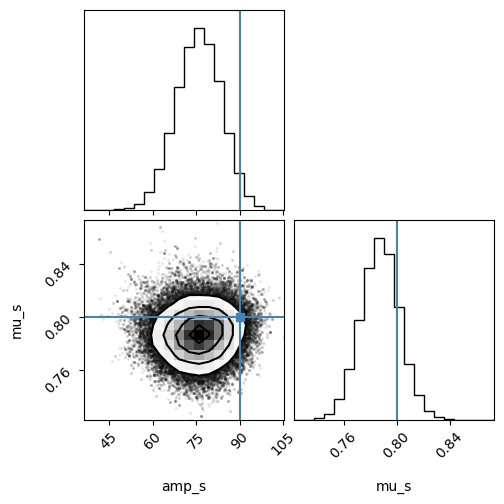

In [184]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

### Neural posterior estimation (NPE)

In [99]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [111]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


Construct a neural posterior estimator. It uses a normalizing flow as a (conditional) posterior density estimator, and a feature-extraction network that aligns the directions of variations in parameters $\theta$ and data $x$.
$$  \mathcal L = -\log p_\phi(\theta\mid s_\varphi(x))$$
where $\{\phi, \varphi\}$ are the parameters of the normalizing flow and featurizer MLP, respectively.

In [112]:
class NeuralPosteriorEstimator(pl.LightningModule):
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Instantiate the NPE class and look at the loss:

In [107]:
npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(x_samples[:64], theta_samples[:64])

tensor([-2.8646, -3.9532, -2.3793, -3.9598, -0.4721, -3.9193, -4.1648, -4.1079,
        -3.8055, -2.6645, -4.3867, -1.5856, -2.2467, -3.2812,  1.3000, -3.8933,
        -3.1823, -3.8068, -1.7736, -1.4777, -2.7323, -4.0634, -3.0050, -1.7647,
        -3.1175, -4.0481,  0.4045, -3.1993, -4.0204,  0.7904, -3.8784, -0.3863,
        -2.7678, -3.6799, -3.3105, -3.6810, -3.3356, -1.5120, -2.7539, -1.8544,
         0.0617, -2.7909, -3.4942, -3.9010, -2.7403, -3.2410, -3.5365,  2.0684,
        -3.7770, -0.7487, -3.8996, -3.0319, -0.2770, -2.8027, -3.3036, -2.7240,
        -3.9457, -1.1398, -3.5251, -3.6639, -3.6110, -2.6895, -4.3354, -2.9663],
       grad_fn=<NegBackward0>)

Train using the same data as before:

In [103]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type       | Params
------------------------------------------
0 | featurizer | Sequential | 74.6 K
1 | flow       | Flow       | 24.3 K
------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Get a test data sample, pass it through the feature extractor, and condition the flow density estimator on it. We get posterior samples by drawing from 
$$\theta \sim p_\phi(\theta\mid s_\varphi(x)).$$

In [108]:
theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

In [109]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

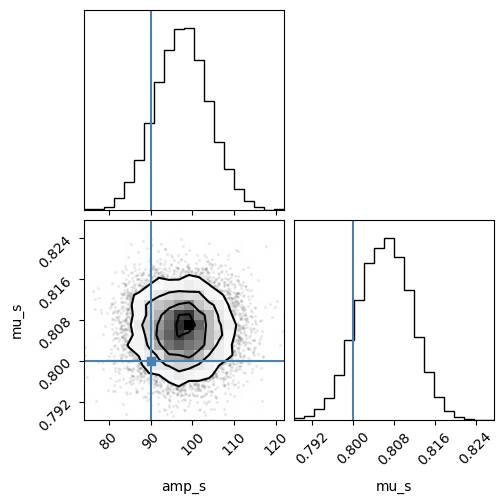

In [110]:
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()
corner.corner(samples_test, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

# A more complicated example: distribution of point sources in a 2D image

Finally, let's look at a more complicated example, one that is closer to a typical application of SBI and where the likelihood is formally intractable.

The forward model simulates a map of point sources with mean counts drawn from a power law (Pareto) distribution. The distribution of the mean counts is given by the following equation:

$$
\frac{\mathrm dn}{\mathrm  ds} = A s^{(\beta - 1)}
$$

where $A$ is the amplitude (amp_b), $s$ is the flux, and $\beta$ is the exponent (exp_b). The fluxes are drawn from a truncated power law with minimum and maximum bounds, $s_\text{min}$ and $s_\text{max}$, respectively.

The number of sources is determined by integrating the power law distribution within the flux limits and taking a Poisson realization:

$$
N_\text{sources} \sim \text{Poisson}\left(-A \frac{s_\text{min}^{(\beta-1)}}{\beta-1}\right)
$$

For each source, a position is randomly assigned within the box of size `box_size`. The fluxes are then binned into a grid with `resolution` number of bins in both x and y directions. The resulting map is convolved with a Gaussian point spread function (PSF) with a standard deviation of `sigma_psf` to account for the spatial resolution of the instrument.

The output is a 2D map of counts, representing the simulated observation of the point sources in the sky.

Text(0, 0.5, 'Pixels')

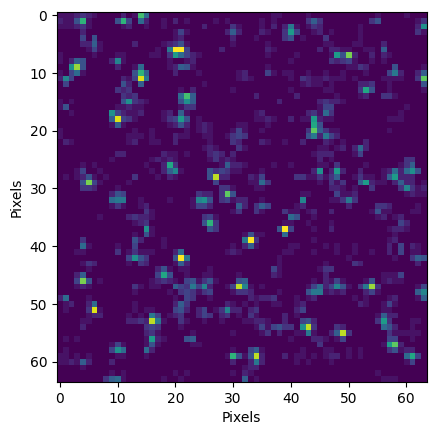

In [204]:
from scipy.stats import binned_statistic_2d
from astropy.convolution import convolve, Gaussian2DKernel


def simulate_sources(amp_b, exp_b, s_min=0.5, s_max=50.0, box_size=1., resolution=64, sigma_psf=0.01):
    """ Simulate a map of point sources with mean counts drawn from a power law (Pareto) distribution dn/ds = amp_b * s ** (exp_b - 1)
    """
    # Get number of sources by analytically integrating dn/ds and taking Poisson realization
    n_sources = np.random.poisson(-amp_b * (s_min ** (exp_b - 1)) / (exp_b - 1))

    # Draw fluxes from truncated power law amp_b * s ** (exp_b - 1), with s_min and s_max as the bounds
    fluxes = draw_powerlaw_flux(n_sources, s_min, s_max, exp_b)

    positions = np.random.uniform(0., box_size, size=(n_sources, 2))
    bins = np.linspace(0, box_size, resolution + 1)

    pixel_size = box_size / resolution
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    mu_signal = binned_statistic_2d(x=positions[:, 0], y=positions[:, 1], values=fluxes, statistic='sum', bins=bins).statistic
    counts = np.random.poisson(convolve(mu_signal, kernel))
                
    return fluxes, counts

def draw_powerlaw_flux(n_sources, s_min, s_max, exp_b):
    """
    Draw from a powerlaw with slope `exp_b` and min/max mean counts `s_min` and `s_max`. From:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sources)
    s_low_u, s_high_u = s_min ** (exp_b + 1), s_max ** (exp_b + 1)
    return (s_low_u + (s_high_u - s_low_u) * u) ** (1.0 / (exp_b + 1.0))

fluxes, counts = simulate_sources(amp_b=200., exp_b=-1.2)
plt.imshow(counts, cmap='viridis', vmax=20)
plt.xlabel("Pixels")
plt.ylabel("Pixels")

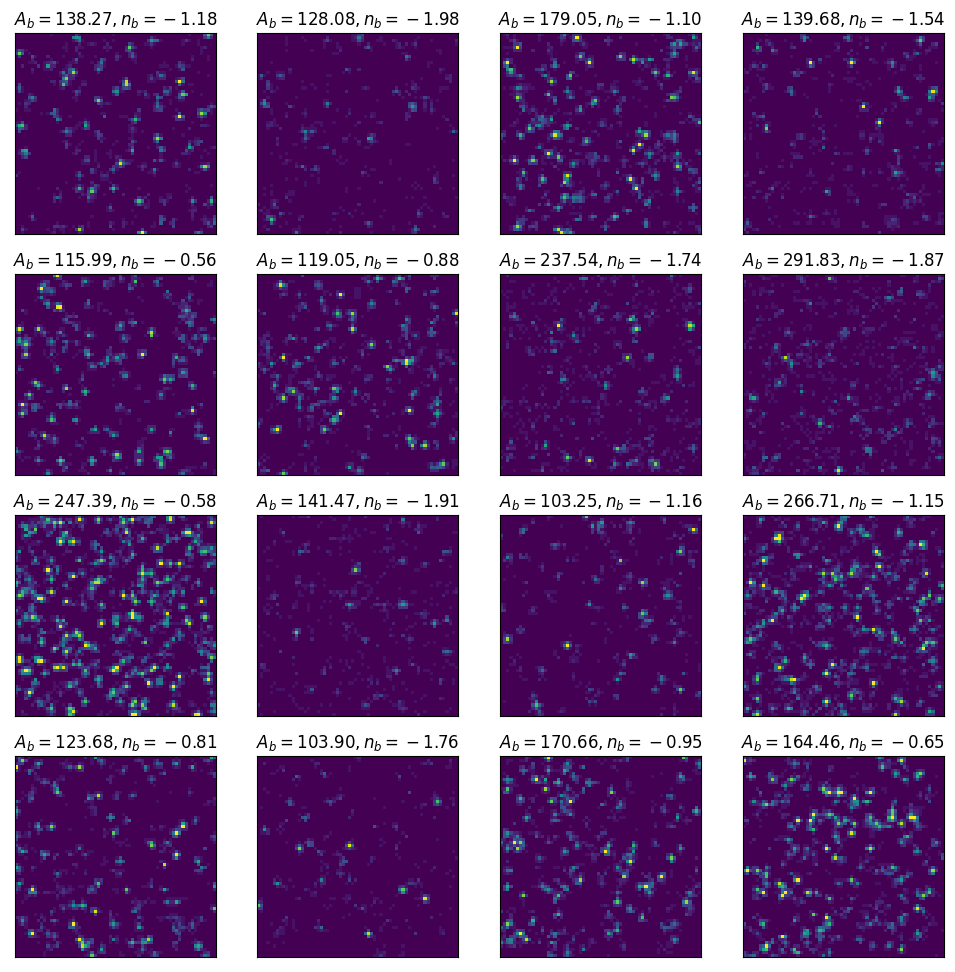

In [205]:
# Draw parameters from the prior
n_params = 16

amp_b_prior = (100., 300.)
exp_b_prior = (-2.0, -0.5)

amp_bs = np.random.uniform(amp_b_prior[0], amp_b_prior[1], n_params)
exp_bs = np.random.uniform(exp_b_prior[0], exp_b_prior[1], n_params)

# Plot the data samples on a grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    fluxes, counts = simulate_sources(amp_b=amp_bs[i], exp_b=exp_bs[i])
    im = ax.imshow(counts, cmap='viridis', vmax=20)
    ax.set_title(f'$A_b={amp_bs[i]:.2f}, n_b={exp_bs[i]:.2f}$')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Explicit likelihood

The (marginal) likelihood, which we would need to plug into something like MCMC, is computationally intractable! This is because it involves an integral over a cumbersome latent space, which consists of all possible number $n$ of sources and their positions $\{z\}=\{x, y\}_{i=1}^{n}$. Let's write this out formally:
$$p(x \mid \theta)=\sum_{n} \int \mathrm{d}^{n} \{z\}\, p\left(n \mid \theta\right) \prod_i^{n} p\left(z_{i} \mid \theta\right) \, p\left(x \mid \theta,\left\{z_{i}\right\}\right)$$

## Implicit inference: Neural posterior estimation

Let's use neural posterior estimation with a normalizing flow again. Get a training sample:

In [206]:
n_train = 10_000

# Sample from prior, then simulate
theta_samples = np.random.uniform(low=[10., -3.], high=[200., -0.99], size=(n_train, 2))
x_samples = np.array([simulate_sources(theta[0], theta[1])[1] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.Tensor(theta_samples)
x_samples = torch.Tensor(x_samples)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std


100%|██████████| 10000/10000 [00:06<00:00, 1476.50it/s]


In [207]:
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


Since we're working with images, use a simple convolutional neural network (CNN) as the feature extractor. The normalizing flow will be conditioned on the output of the CNN.

In [208]:
class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        
        x = x.unsqueeze(1)  # Add channel dim
        
        x = self.pool1(F.leaky_relu(self.conv1(x), negative_slope=0.02))
        x = self.pool2(F.leaky_relu(self.conv2(x), negative_slope=0.02))

        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)

        return x

In [209]:
npe = NeuralPosteriorEstimator(featurizer=CNN(output_dim=32), d_context=32)
npe.loss(x_samples[:64], theta_samples[:64])

tensor([4.7043, 5.0446, 4.8666, 4.7876, 4.7634, 4.9258, 4.6907, 4.8628, 4.7768,
        4.8856, 5.0285, 4.6154, 4.7183, 4.7666, 4.9203, 4.8649, 5.0904, 4.6504,
        4.6543, 4.6448, 4.6778, 5.1378, 4.8319, 4.8339, 4.7608, 5.0057, 4.5516,
        4.8812, 4.9021, 4.6560, 4.8347, 4.6023, 4.7826, 4.8307, 4.8774, 4.5799,
        4.5457, 4.6967, 4.8012, 5.1448, 4.9482, 4.6708, 4.9610, 4.7108, 4.7626,
        4.5403, 4.7233, 4.8936, 4.8874, 4.6122, 4.7773, 4.8843, 4.7262, 4.9750,
        4.5888, 4.7933, 4.7920, 4.5726, 4.9222, 4.5912, 4.5724, 4.7746, 4.6585,
        4.6604], grad_fn=<NegBackward0>)

In [210]:
trainer = pl.Trainer(max_epochs=15)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type | Params
------------------------------------
0 | featurizer | CNN  | 265 K 
1 | flow       | Flow | 30.5 K
------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.184     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [211]:
npe = npe.eval()

Get a test map, extract features, condition normalizing flow, extract samples.

In [212]:
params_test = np.array([15., -1.4])
x_test = simulate_sources(params_test[0], params_test[1])[1]

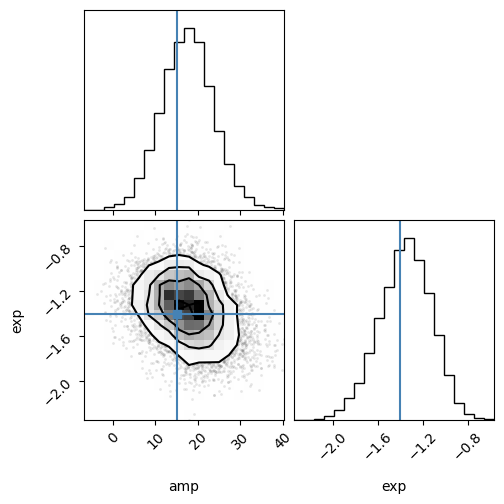

In [213]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm.unsqueeze(0))

samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

corner.corner(samples_test, labels=["amp", "exp"], truths=params_test);

## Test of statistical coverage

We can do some checks to make sure that our posterior has the correct statistical interpretation. In particular, let's test the posterior statistical coverage by evaluating how well the Highest Posterior Density (HPD) intervals capture the true parameter values.

The **Highest Posterior Density (HPD)** interval is a region in the parameter space that contains the most probable values for a given credible mass (e.g., 95% or 99%). In other words, it is the shortest interval that contains the specified credible mass of the posterior distribution. This is one of summarizing a posterior distribution.

**Nominal coverage** is the probability, or the proportion of the parameter space, that the HPD interval is intended to contain. For example, if the nominal coverage is 0.95, the HPD interval should theoretically contain the true parameter value 95% of the time.

**Empirical coverage** is the proportion of true parameter values that actually fall within the HPD interval, based on a set of test cases or simulations.

For a perfectly calibrated posterior, empirical coverage = nominal coverage for all credibility levels.

In [214]:
n_test = 200  # How many test samples to draw for coverage test

# Get samples 
x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

# and featurize
context = npe.featurizer(x_test_norm)

# Get posterior for all samples together in a batch
samples_test = npe.flow.sample(num_samples=1000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

In [215]:
def hpd(samples, credible_mass=0.95):
    """Compute highest posterior density (HPD) of array for given credible mass."""
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * sorted_samples.shape[0]))
    n_intervals = sorted_samples.shape[0] - interval_idx_inc
    interval_width = np.zeros(n_intervals)
    for i in range(n_intervals):
        interval_width[i] = sorted_samples[i + interval_idx_inc] - sorted_samples[i]
    hdi_min = sorted_samples[np.argmin(interval_width)]
    hdi_max = sorted_samples[np.argmin(interval_width) + interval_idx_inc]
    return hdi_min, hdi_max

hpd(samples_test[0, :, 0], credible_mass=0.2)

(13.003548, 15.589531)

In [218]:
p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

for i_param in range(2):
    for i, sample in enumerate(samples_test[:, :, i_param]):
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = hpd(sample, credible_mass=p_nominal)
            if hdi_min < params_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

Text(0.5, 1.0, 'Coverage for exponent')

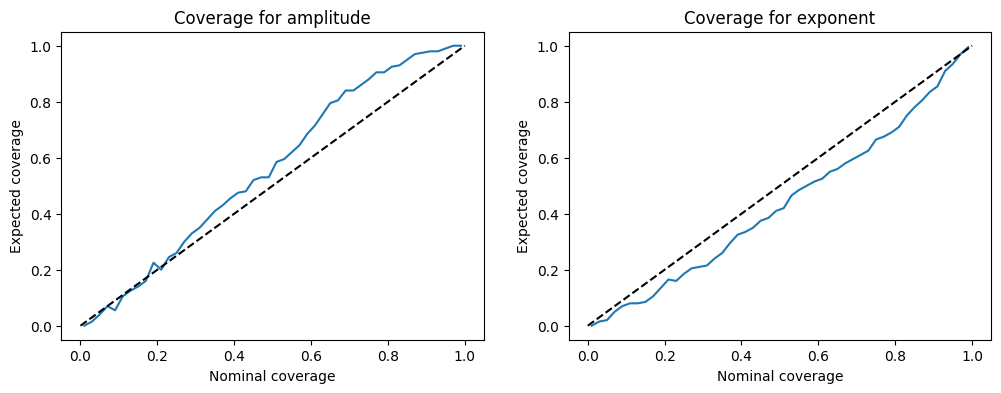

In [219]:
# Make two plots, one for each parameter

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(p_nominals, contains_true[0].sum(0) / n_test)
ax[0].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[0].set_xlabel("Nominal coverage")
ax[0].set_ylabel("Expected coverage")
ax[0].set_title("Coverage for amplitude")



ax[1].plot(p_nominals, contains_true[1].sum(0) / n_test)
ax[1].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[1].set_xlabel("Nominal coverage")
ax[1].set_ylabel("Expected coverage")
ax[1].set_title("Coverage for exponent")

# Further reading

- [The frontier of simulation-based inference](https://arxiv.org/abs/1911.01429) (Cranmer, Brehmer, Louppe): Review paper
- [simulation-based-inference.org](http://simulation-based-inference.org/): List of papers and resources
- [awesome-neural-sbi](https://github.com/smsharma/awesome-neural-sbi): List of papers and resources